# Image scene classification using Neural Network

In [1]:
import numpy as np 
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import Xception

In [2]:
base_path = './storage/dataset/'
train_path = './storage/dataset/seg_train'
img_size = 150
train_data = {}
test_data = {}
labels = []

## Data Expoloration 

In [3]:
#method to print directory structure
def explore_dir(path, train_data, test_data, labels):
    print("Directory structure of base directory", base_path)
    n_train = 0
    n_test = 0
    for dr in os.listdir(base_path):
        print("\t",dr)
        if dr == 'seg_pred':
            print("\t\t Number of files", len(os.listdir(base_path + dr + '/' )))
        else:
            for dr2 in os.listdir(base_path + dr + '/'):
                            print('\t\t\t',dr2)
                            print("\t\t\t\t Number of files", len(os.listdir(base_path + dr + '/' + dr2 + "/")))
                            if (dr == 'seg_train'):
                                n_train = n_train + len(os.listdir(base_path + dr + '/' + dr2 + "/"))
                                train_data[dr2] =  len(os.listdir(base_path + dr + '/' + dr2 + "/"))
                                labels.append(dr2)
                            elif(dr == 'seg_test'):
                                n_test = n_test + len(os.listdir(base_path + dr + '/' + dr2 + "/"))
                                test_data[dr2] =  len(os.listdir(base_path + dr + '/' + dr2 + "/"))

In [4]:
#method to show sample images form train set
def sample_plots(path):
    print_dataset = ImageDataGenerator()
    print_gen = print_dataset.flow_from_directory(
               path,  # this is the target directory
                target_size=(img_size, img_size),
                batch_size=30,
                classes = labels)  
    figsize=(12,13)
    rows=5
    interp=False
    ims, titles = next(print_gen)
    if type(ims[0]) is np.ndarray:
        ims=np.array(ims).astype(np.uint8)
        if (ims.shape[-1]!=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            val, = np.where(titles[i]==1)
            sp.set_title(labels[val[0]], fontsize=13)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

#### Lets explore directory structure for the dataset and see how our data is stored

In [5]:
explore_dir(base_path, train_data, test_data, labels)

Directory structure of base directory ./storage/dataset/
	 seg_test
			 buildings
				 Number of files 437
			 sea
				 Number of files 510
			 glacier
				 Number of files 553
			 mountain
				 Number of files 525
			 forest
				 Number of files 474
			 street
				 Number of files 501
	 seg_pred
		 Number of files 7302
	 seg_train
			 buildings
				 Number of files 2191
			 sea
				 Number of files 2274
			 glacier
				 Number of files 2404
			 mountain
				 Number of files 2512
			 forest
				 Number of files 2271
			 street
				 Number of files 2382


#### Print some sample images 

Found 14034 images belonging to 6 classes.


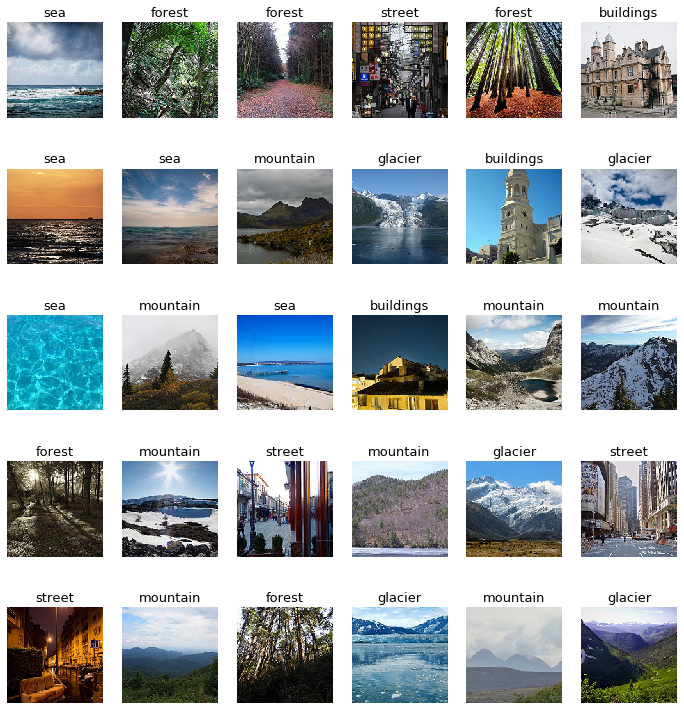

In [6]:
sample_plots(train_path)

#### Lets see the amount of test and train data we have for each class 

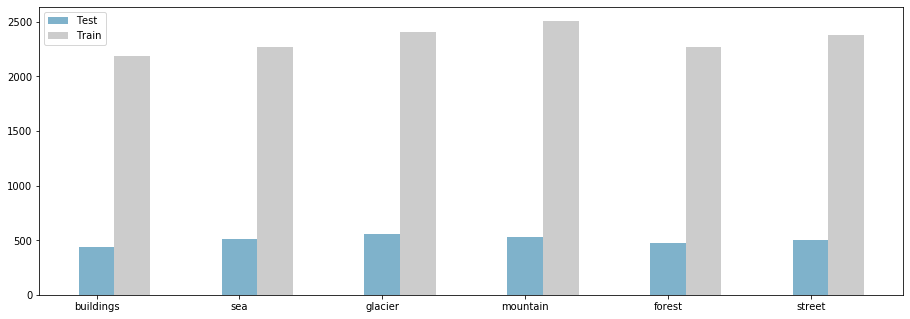

In [7]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
X = np.arange(6)
ax.bar(X, tuple(test_data.values()), color=(0, 0.4, 0.6, 0.5), width=0.25)
ax.bar(X + 0.25, tuple(train_data.values()), color=(0.8, 0.8, 0.8, 1), width=0.25)
ax.set_xticks(X)
ax.set_xticklabels(labels)
#ax.set_xlabel("Classes")
#ax.set_ylabel("# of cases")
ax.legend(labels=['Test', 'Train'])
plt.show()

## Hyperparameter Tuning

In [8]:
def image_datagen(path):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
#        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
#        zoom_range=0.3,
        fill_mode='nearest',
        validation_split=0.2        
        )
    train_path = path +'/seg_train'    
    train_genrator = train_datagen.flow_from_directory(
        train_path,
        subset="training",
        shuffle=True,
        target_size=(img_size, img_size))
    validation_generator = train_datagen.flow_from_directory(
        train_path,
        subset="validation",
        target_size=(img_size, img_size))    
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_path = path +'/seg_test'
    test_genrator = test_datagen.flow_from_directory(
        test_path,
        shuffle=True,
        target_size=(img_size, img_size))    
    return train_genrator, test_genrator, validation_generator

In [15]:
def model_create_optmiser(optimizer='Adam'):
    model = tf.keras.models.Sequential()

    # input layer 
    model.add(tf.keras.layers.Conv2D(64, (3,3), input_shape=(img_size, img_size, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    # Hidden layer 2
    model.add(tf.keras.layers.Conv2D(32, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))  
    
    #flatting
    model.add(tf.keras.layers.Flatten())    
    model.add(tf.keras.layers.Dense(units=128))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Dense(units=6))
    model.add(tf.keras.layers.Activation('softmax'))
    
   # model compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [22]:
train_datagen , test_datagen, val_datagen = image_datagen(base_path)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [17]:
batch_size_list = [30, 40, 50]
epochs_list = [24, 32]
optimizer_list = ['SGD', 'RMSprop', 'Adam']

parameters = dict(batch_size=batch_size_list, epochs=epochs_list, optimizer=optimizer_list)
model = KerasClassifier(build_fn=model_create_optmiser, verbose=0)

grid = GridSearchCV(estimator=model, param_grid=parameters, cv=3)
X_train, y_train =  train_datagen.next()
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']

params = grid_result.cv_results_['params']

#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.436364 using {'batch_size': 40, 'epochs': 32, 'optimizer': 'Adam'}


The best accuracy score is the using Best: 0.436364 using {'batch_size': 40, 'epochs': 32, 'optimizer': 'Adam'} so we will be using Adam for further parameter tunning. 

In [25]:
def model_create_optmiser(learn_rate=0.01):
    model = tf.keras.models.Sequential()

    # input layer 
    model.add(tf.keras.layers.Conv2D(64, (3,3), input_shape=(img_size, img_size, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    
    # Hidden layer 2
    model.add(tf.keras.layers.Conv2D(32, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))  
    
    #flatting
    model.add(tf.keras.layers.Flatten())    
    model.add(tf.keras.layers.Dense(units=128))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Dense(units=6))
    model.add(tf.keras.layers.Activation('softmax'))
    
     #optimizer
    optimizer = tf.keras.optimizers.Adam(lr=learn_rate)
  
    # model compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [26]:
batch_size_list = [16,24,32]
epochs_list = [20, 30, 40]

lr = [0.0001, 0.001, 0.01]
momentum = [0.4, 0.5, 0.6]
parameters = dict(learn_rate=lr, batch_size=batch_size_list, epochs=epochs_list)
X_train, y_train =  train_datagen.next()
model = KerasClassifier(build_fn=model_create_optmiser, verbose=0)

grid = GridSearchCV(estimator=model, param_grid=parameters, cv=3)
#X_train, y_train =  train_datagen.next()
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']

params = grid_result.cv_results_['params']


Best: 0.439394 using {'batch_size': 16, 'epochs': 20, 'learn_rate': 0.001}


We get the best score using {'batch_size': 16, 'epochs': 20, 'learn_rate': 0.001} so we will be using these to tune the model. 

## Modle Training

In [7]:
batch_size = 16
epochs = 20 
learn_rate = 0.001

In [11]:
def model_create_optmiser(learn_rate):
    model = tf.keras.models.Sequential()

    # input layer 
    model.add(tf.keras.layers.Conv2D(64, (3,3), input_shape=(img_size, img_size, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    # Hidden layer 2
    model.add(tf.keras.layers.Conv2D(32, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))  
    
    #flatting
    model.add(tf.keras.layers.Flatten())    
    model.add(tf.keras.layers.Dense(units=128))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Dense(units=6))
    model.add(tf.keras.layers.Activation('softmax'))
    
     #optimizer
    optimizer = tf.keras.optimizers.Adam(lr=learn_rate)
  
    # model compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [13]:
model_final = model_create_optmiser(learn_rate=learn_rate)

In [14]:
def image_datagen_fnl(path):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
#        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
#        zoom_range=0.3,
        fill_mode='nearest',
        validation_split=0.2        
        )
    train_path = path +'/seg_train'
    
    train_genrator = train_datagen.flow_from_directory(
        train_path,
        subset="training",
        target_size=(img_size, img_size),
        shuffle=True,
        batch_size=batch_size)
    
    validation_generator = train_datagen.flow_from_directory(
        train_path,
        subset="validation",
        target_size=(img_size, img_size),
        batch_size=batch_size)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_path = path +'/seg_test'
    
    test_genrator = test_datagen.flow_from_directory(
        test_path,
        target_size=(img_size, img_size),
        shuffle=True,        
        batch_size=batch_size)    
    
    return train_genrator, test_genrator, validation_generator

In [15]:
train_datagen_fnl , test_datagen_fnl, val_datagen_fnl = image_datagen_fnl(base_path)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [8]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model_final.fit(train_datagen_fnl,
                          epochs=epochs,
                          validation_data=val_datagen_fnl)

Train for 702 steps, validate for 176 steps
Epoch 1/20
702/702 [==============================] - 96s 136ms/step - loss: 1.3549 - accuracy: 0.4410 - val_loss: 1.1066 - val_accuracy: 0.5121
Epoch 2/20
702/702 [==============================] - 86s 123ms/step - loss: 1.0671 - accuracy: 0.5708 - val_loss: 1.0462 - val_accuracy: 0.5852
Epoch 3/20
702/702 [==============================] - 88s 126ms/step - loss: 0.9601 - accuracy: 0.6280 - val_loss: 0.8574 - val_accuracy: 0.6862
Epoch 4/20
702/702 [==============================] - 86s 122ms/step - loss: 0.9137 - accuracy: 0.6489 - val_loss: 0.8360 - val_accuracy: 0.6890
Epoch 5/20
702/702 [==============================] - 82s 117ms/step - loss: 0.8526 - accuracy: 0.6750 - val_loss: 0.8192 - val_accuracy: 0.6947
Epoch 6/20
702/702 [==============================] - 91s 130ms/step - loss: 0.8207 - accuracy: 0.6897 - val_loss: 0.7971 - val_accuracy: 0.7115
Epoch 7/20
702/702 [==============================] - 97s 138ms/step - loss: 0.8138 - 

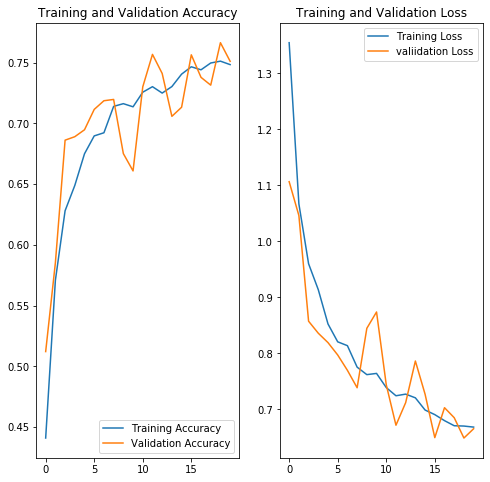

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='valiidation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
scoreSeg = model_final.evaluate(test_datagen_fnl, verbose=0)
print("Test loss, Test accuracy:", scoreSeg)

Test loss, Test accuracy: [0.6274407579702266, 0.76566666]


In [14]:
model_final.save('saved_model/normal_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/normal_model/assets


In [16]:
model_final.save('saved_model/normal_model.h5')

# Image scene classification using Transfer Learning

In [1]:
import numpy as np 
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import vgg16 
import pandas as pd

base_path = './storage/dataset/'
train_path = './storage/dataset/seg_train'
img_size = 150
train_data = {}
test_data = {}
labels = []

In [2]:
def image_datagen(path):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
#        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
#        zoom_range=0.3,
        fill_mode='nearest',
        validation_split=0.2        
        )
    train_path = path +'/seg_train'    
    train_genrator = train_datagen.flow_from_directory(
        train_path,
        subset="training",
        shuffle=True,
        target_size=(img_size, img_size))
    validation_generator = train_datagen.flow_from_directory(
        train_path,
        subset="validation",
        target_size=(img_size, img_size))    
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_path = path +'/seg_test'
    test_genrator = test_datagen.flow_from_directory(
        test_path,
        shuffle=True,
        target_size=(img_size, img_size))    
    return train_genrator, test_genrator, validation_generator

In [3]:
train_datagen , test_datagen, val_datagen = image_datagen(base_path)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [4]:
def model_create_optmiser_tnfrlr(optimizer='Adam'):
    base_model = vgg16.VGG16( include_top=False, weights="imagenet", input_shape=(img_size, img_size, 3))
    base_model.trainable = False
    for layer in base_model.layers:
        if ('block5'in layer.name):   # or ('block4'in layer.name):
            layer.trainable = True 
    
    x_op = base_model.output
    x = tf.keras.layers.Flatten()(x_op)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    output = tf.keras.layers.Dense(6, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.inputs, outputs=output) 
      
    #optimizer
#    optimizer = tf.keras.optimizers.Adam(lr=learn_rate)    
    # model compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
batch_size_list = [16, 24, 32]
epochs_list = [5, 10, 15, 20]
optimizer_list = ['SGD', 'RMSprop', 'Adam']

parameters = dict(batch_size=batch_size_list, epochs=epochs_list, optimizer=optimizer_list)
model_transfer = KerasClassifier(build_fn=model_create_optmiser_tnfrlr, verbose=0)

grid = GridSearchCV(estimator=model_transfer, param_grid=parameters, cv=3)
X_train, y_train =  train_datagen.next()
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.439394 using {'batch_size': 16, 'epochs': 10, 'optimizer': 'SGD'}


Best: 0.530303 using {'batch_size': 24, 'epochs': 15, 'optimizer': 'SGD'}

In [5]:
def model_create_optmiser_tnfrlr(learn_rate, momentum):
    base_model = vgg16.VGG16( include_top=False, weights="imagenet", input_shape=(img_size, img_size, 3))
    base_model.trainable = False
    for layer in base_model.layers:
        if ('block5'in layer.name):   # or ('block4'in layer.name):
            layer.trainable = True 
    
    x_op = base_model.output
    x = tf.keras.layers.Flatten()(x_op)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    output = tf.keras.layers.Dense(6, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.inputs, outputs=output)  
      
    #optimizer
    optimizer = tf.keras.optimizers.SGD(lr=learn_rate, momentum=momentum)    
    # model compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
batch_size_list = [16, 24]
epochs_list = [15, 20, 25]
lr = [0.001, 0.01]
momentum = [0.4, 0.5, 0.6]

parameters = dict(batch_size=batch_size_list, epochs=epochs_list, learn_rate=lr, momentum=momentum)
model_transfer = KerasClassifier(build_fn=model_create_optmiser_tnfrlr, verbose=0)

grid = GridSearchCV(estimator=model_transfer, param_grid=parameters, cv=3)
X_train, y_train =  train_datagen.next()
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.503030 using {'batch_size': 24, 'epochs': 25, 'learn_rate': 0.01, 'momentum': 0.6}


In [2]:
def model_create_optmiser_tnfrlr(learn_rate, momentum):
    base_model = vgg16.VGG16( include_top=False, weights="imagenet", input_shape=(img_size, img_size, 3))
    base_model.trainable = False
    for layer in base_model.layers:
        if ('block5'in layer.name):   # or ('block4'in layer.name):
            layer.trainable = True 
    
    x_op = base_model.output
    x = tf.keras.layers.Flatten()(x_op)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    output = tf.keras.layers.Dense(6, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.inputs, outputs=output) 
    
    #optimizer
    optimizer = tf.keras.optimizers.SGD(lr=learn_rate, momentum=momentum)      
    # model compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [3]:
batch_size = 24
epochs = 10
learn_rate = 0.01
momentum = 0.6

In [4]:
def image_datagen_fnl(path):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
#        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
#        zoom_range=0.3,
        fill_mode='nearest',
        validation_split=0.2        
        )
    train_path = path +'/seg_train'
    
    train_genrator = train_datagen.flow_from_directory(
        train_path,
        subset="training",
        target_size=(img_size, img_size),
        shuffle=True,
        batch_size=batch_size)
    
    validation_generator = train_datagen.flow_from_directory(
        train_path,
        subset="validation",
        target_size=(img_size, img_size),
        batch_size=batch_size)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_path = path +'/seg_test'
    
    test_genrator = test_datagen.flow_from_directory(
        test_path,
        target_size=(img_size, img_size),
        shuffle=True,        
        batch_size=batch_size)    
    
    return train_genrator, test_genrator, validation_generator

In [5]:
train_datagen_fnl , test_datagen_fnl, val_datagen_fnl = image_datagen_fnl(base_path)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [6]:
model_transfer = model_create_optmiser_tnfrlr(learn_rate=learn_rate, momentum=momentum )

In [25]:
layers = [(layer, layer.name, layer.trainable) for layer in model_transfer.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_4,False
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,False


In [7]:
history = model_transfer.fit(test_datagen_fnl,
                          epochs=epochs,
                          validation_data=val_datagen_fnl)

Train for 125 steps, validate for 117 steps
Epoch 1/10
125/125 [==============================] - 36s 290ms/step - loss: 0.7410 - accuracy: 0.7193 - val_loss: 0.9051 - val_accuracy: 0.6655
Epoch 2/10
125/125 [==============================] - 30s 240ms/step - loss: 0.3984 - accuracy: 0.8643 - val_loss: 0.8014 - val_accuracy: 0.6972
Epoch 3/10
125/125 [==============================] - 30s 240ms/step - loss: 0.3101 - accuracy: 0.8980 - val_loss: 0.7866 - val_accuracy: 0.7275
Epoch 4/10
125/125 [==============================] - 30s 240ms/step - loss: 0.2310 - accuracy: 0.9187 - val_loss: 0.7733 - val_accuracy: 0.7236
Epoch 5/10
125/125 [==============================] - 30s 239ms/step - loss: 0.1819 - accuracy: 0.9377 - val_loss: 0.9285 - val_accuracy: 0.6919
Epoch 6/10
125/125 [==============================] - 30s 241ms/step - loss: 0.1238 - accuracy: 0.9560 - val_loss: 0.8512 - val_accuracy: 0.7282
Epoch 7/10
125/125 [==============================] - 30s 240ms/step - loss: 0.0910 - 

In [8]:
scoreSeg = model_transfer.evaluate(test_datagen_fnl, verbose=0)
print("Test loss, Test accuracy:", scoreSeg)

Test loss, Test accuracy: [0.011355374849867076, 0.99666667]


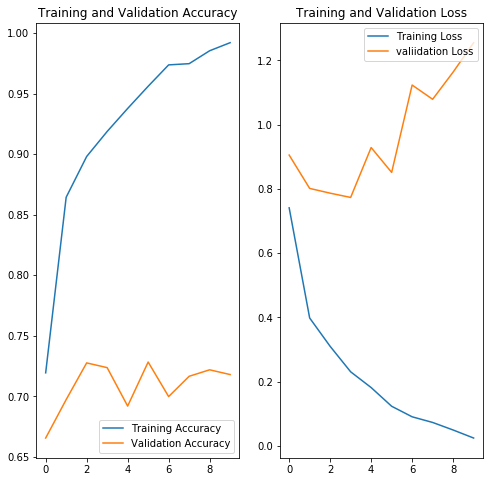

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='valiidation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
model_transfer.save('saved_model/transfer_lrn_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/transfer_lrn_model/assets


In [11]:
model_transfer.save('saved_model/transfer_lrn_model.h5')